# Taking Netflix By Storm: The Correlation between Watching and the Weather

## Introduction

In [1]:
# load in netflix viewing data
import pandas as pd
import numpy as np

viewing_df = pd.read_csv("netflix_viewing_data.csv")

In [47]:
# load in weather data
spokane_weather_df = pd.read_csv("spokane_temp_precip_data.csv")

#clean precipitation column
precip_ser = spokane_weather_df["Precipitation"]
# if rain then 1, if not then 0
for i in range (0, len(precip_ser)):
    if precip_ser[i] > 0:
        precip_ser.replace(precip_ser[i], 1, inplace=True)
        
# find median for future split
temp_ser = spokane_weather_df["High"]
temp_ser.sort_values()
temp_median = temp_ser.median()

# add column to keep track of low/high
temp_ser = spokane_weather_df["High"] # get the unsorted series
low_high_ser = pd.Series(dtype=int)
for i in range (0, len(temp_ser)):
    if temp_ser[i] < temp_median:
        low_high_ser = low_high_ser.append(pd.Series("Low"))
    elif temp_ser[i] == temp_median or temp_ser[i] > temp_median:
        low_high_ser = low_high_ser.append(pd.Series("High"))
        
spokane_weather_df["Temp Category"] = low_high_ser.values
spokane_weather_df.to_csv("spokane_temp_precip_clean_data.csv")

In [115]:
# create column that sums the viewing number for each date
date_col = viewing_df["Date"]
time_col = viewing_df["Length"]
total_watch_df = pd.DataFrame()
dates_no_repeats = pd.Series(dtype=int)
total_watch_ser = pd.Series(dtype=int)

for i in range (8, 11):
    for j in range(1,31):
        if i == 8 and j >= 29:
            date_str = str(i) + "/" + str(j) + "/20"
            dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))
        elif i == 9 or i == 10:
            date_str = str(i) + "/" + str(j) + "/20"
            dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))

total_watch_df["Date"] = dates_no_repeats.values
date_ser = total_watch_df["Date"]

for i in range (len(total_watch_df["Date"])):
    total_watch_ser = total_watch_ser.append(pd.Series(0))

total_watch_df["Viewing Time"] = total_watch_ser.values

watch_ser = total_watch_df["Viewing Time"]


for i in range(len(date_col)):
    date = date_col[i]
    for j in range(0, len(total_watch_df["Date"])):
        target_date = date_ser[j]
        if date == target_date:
            new_num = watch_ser[j] + time_col[i]
            watch_ser[j] = new_num
            #total_watch_df.loc["Viewing time", j] = new_num
            
#total_watch_df["Viewing Time"] = watch_ser.values 
print(total_watch_df)

        Date  Viewing Time
0    8/29/20             0
1    8/30/20             0
2     9/1/20            44
3     9/2/20           111
4     9/3/20             0
..       ...           ...
57  10/26/20             0
58  10/27/20            21
59  10/28/20            42
60  10/29/20             0
61  10/30/20           292

[62 rows x 2 columns]


<ipython-input-115-90932bcf5dbc>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watch_ser[j] = new_num


Text(0, 0.5, 'Minutes watched')

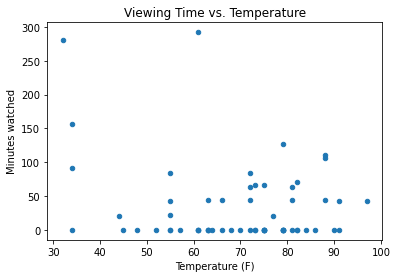

In [121]:
# join the two datasets together
merged_netflix_weather_df = total_watch_df.merge(spokane_weather_df, on="Date")
merged_netflix_weather_df.to_csv("merged_netflix_viewing_weather.csv")

# create a scatter plot showing the initial relationship between the two data sets
import numpy as np
import matplotlib.pyplot as plt

plt.title("Viewing Time vs. Temperature")
plt.scatter(merged_netflix_weather_df["High"], merged_netflix_weather_df["Viewing Time"], s=20)
plt.xlabel("Temperature (F)")
plt.ylabel("Minutes watched")

In [4]:
# split the dataset
low_temp_df = pd.DataFrame()
high_temp_df = pd.DataFrame()
grouped_by_temp_category = merged_netflix_weather_df.groupby("Temp Category")
for group_name, group_df in grouped_by_temp_category:
    if group_name == "Low":
        low_temp_df = group_df
    elif group_name == "High":
        high_temp_df = group_df

# find mean viewing of both groups
viewing_time_low_ser = low_temp_df["Length"]
viewing_time_high_ser = high_temp_df["Length"]
print("Mean of low category", viewing_time_low_ser.mean())
print("Mean of high category", viewing_time_high_ser.mean())
print()

# find the standard deviation of each group
print("Standard deviation of low category", viewing_time_low_ser.std())
print("Standard deviation of high category", viewing_time_high_ser.std())

Mean of low category 19.21212121212121
Mean of high category 15.745098039215685

Standard deviation of low category 17.50122206855207
Standard deviation of high category 16.152824071666107


In [5]:
# Find the Confidence Interval at 97.5%
#low weather 
Xbar_low = viewing_time_low_ser.mean()
std_low = viewing_time_low_ser.std()
n = len(viewing_time_low_ser)
t = 2.000
margin_of_error = t * std_low / np.sqrt(n)
conf_interval_low_temp = (Xbar_low - margin_of_error, Xbar_low + margin_of_error)
print("Low temp confidence interval:", conf_interval_low_temp)

#high weather 
Xbar_high = viewing_time_high_ser.mean()
std_high = viewing_time_high_ser.std()
n = len(viewing_time_high_ser)
t = 2.000
margin_of_error = t * std_high / np.sqrt(n)
conf_interval_high_temp = (Xbar_high - margin_of_error, Xbar_high + margin_of_error)
print("High temp confidence interval:", conf_interval_high_temp)

Low temp confidence interval: (14.903618175364258, 23.520624248878164)
High temp confidence interval: (11.22140246954323, 20.26879360888814)


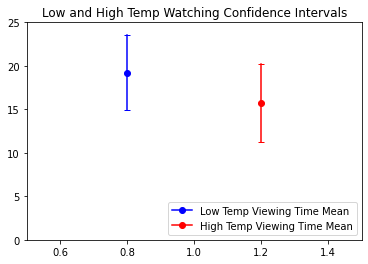

In [6]:
## graph them
plt.figure()
plt.title("Low and High Temp Watching Confidence Intervals")

plt.plot([.8, .8], conf_interval_low_temp, marker="_", color="blue")
plt.plot([.8], [Xbar_low], marker="o", color="blue", label="Low Temp Viewing Time Mean")

plt.plot([1.2, 1.2], conf_interval_high_temp, marker="_", color="red")
plt.plot([1.2], [Xbar_high], marker="o", color="red", label="High Temp Viewing Time Mean")

#set x and y limits
plt.ylim([0, 25])
plt.xlim([0.5, 1.5])
plt.legend(loc='lower right')

TODO:
* create a hypothesis for testing(Go through all 5 steps) (Sunday)
* write an introduction/commentary throughout (Sunday)

## Data Analysis